In [3]:
import pandas as pd
import sys
import numpy as np
import os
import json
import re
import torch
import ast
import cv2
import io
from PIL import Image, ImageDraw
from torch import Tensor
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

import math
from math import sqrt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Custom implementation
from RPN_custom import RPN_custom


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Define functions

In [4]:
from torchvision.transforms import functional as F

def collate_fn(batch):
    return tuple(zip(*batch))



def resize_bbox(image_shape, newsize, bbox):
    x1, y1, w, h = bbox
    w_conv = newsize[0]/image_shape[0]
    h_conv = newsize[1]/image_shape[1]
    (x1, y1, w, h) = (x1*w_conv, y1*h_conv, w*w_conv, h*h_conv)
    return x1, y1, w, h




def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    b1x1,b1y1,b1x2,b1y2 = bb1[0],bb1[1],bb1[2],bb1[3]
    b2x1,b2y1,b2x2,b2y2 = bb2[0],bb2[1],bb2[2],bb2[3]
    
    
    assert b1x1 < b1x2
    assert b1y1 < b1y2
    assert b2x1 < b2x2
    assert b2y1 < b2y2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1x1, b2x1)
    y_top = max(b1y1, b2y1)
    x_right = min(b1x2, b2x2)
    y_bottom = min(b1y2, b2y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (b1x2 - b1x1) * (b1y2 - b1y1)
    bb2_area = (b2x2 - b2x1) * (b2y2 - b2y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

### Dataloader

In [9]:
class TableBank():
    def __init__(self,images_path, df, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
       
        self.annotations = df
        self.images_path = images_path
        #self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.images_path,
                                self.annotations.iloc[idx]['filename'])
        
        image = Image.open(img_path).convert("RGB")
        image_shape = image.size
        newsize = (550,700)
        image = image.resize(newsize,resample=Image.BILINEAR)
        bboxes = ast.literal_eval(self.annotations.iloc[idx]['BoundingBoxes'])

        #boxes = np.zeros((1,4), dtype=np.float32)
        areas = []
        boxes = []
        for i in range(len(bboxes)):
            (x1, y1, w, h) = resize_bbox(image_shape, newsize, bboxes[i])
            x2 = x1+w
            y2 = y1+h
            boxes.append([x1,y1,x2,y2])
            areas.append((h*w))
            #if area < h*w:
            #    area = h*w
            #    boxes[0,:] = [x1,y1,x2,y2]

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((len(boxes)), dtype=torch.int64)
        #labels = torch.ones(1, dtype = torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.int64)
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = areas
        target["iscrowd"] = iscrowd        

        image = F.to_tensor(image)

        return image, target,self.annotations.iloc[idx]['filename']

# Load Data and Model

In [6]:
#Loading a sample of 100 images that are to be predicted by the model
sampledf = pd.read_pickle("./sampledf.pkl")

In [13]:
#Values for data transformation in network. 
min_size = 550  
max_size = 700  

#Calculated on training data:
image_means = [0.9492,0.9492,0.9492]
image_stds = [0.1158,0.1158,0.1158]



In [14]:
#Define model framework

######################
#possible model names:

#resnet18
#resnet50
#resnet152
######################


model_name = 'resnet152'

num_classes = 2
backbone = resnet_fpn_backbone(model_name, True)
model = FasterRCNN(backbone, num_classes, min_size=min_size, max_size=max_size, image_mean = image_means, image_std = image_stds)






### Define model path

#OBS! the model.pt file is not included in the repos and should be downloaded from https://1drv.ms/u/s!AuhjKS1JyxUYgwfRlPo6F7Z-q2A8?e=G6l0Jg and added to the repository.

In [17]:
# INPUT YOUR OWN PATH TO MODEL
model_path = "resnet152/model.pt"

In [18]:
model.load_state_dict(torch.load(model_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.9492, 0.9492, 0.9492], std=[0.1158, 0.1158, 0.1158])
      Resize(min_size=(550,), max_size=700, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsa

### Create dataloader 

In [23]:
images_path = 'Detection/showcase_images/'
TBtest = TableBank(images_path, sampledf)
dataloader = torch.utils.data.DataLoader(TBtest, batch_size=8,
                                sampler=None, num_workers=0, collate_fn=collate_fn)

# Get predictions on 100

In [31]:
sampledf['predictions'] = None
sampledf['scores'] = None
sampledf = sampledf.set_index('filename')

In [32]:

from time import time

t = time()  
   
model.to(device)
model.eval()
    
for ct, obj in enumerate(dataloader):
    img = obj[0]
    annotations = obj[1]
    filename = obj[2]
    with(torch.no_grad()):
        #Get predictions 
        images = list(image.to(device) for image in img)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(images)
        
    #input predictions in df for later calculations
    count = 0
    for pred,idx in zip(predictions,filename):
       
        
        sampledf.loc[idx]['BoundingBoxes'] = obj[1][count]['boxes'].numpy()
        sampledf.loc[idx]['predictions'] = pred['boxes'].cpu().numpy()
        sampledf.loc[idx]['scores'] = pred['scores'].cpu().numpy()
        
        count+=1 
    #print(ct)
    if ct % 2 == 0:
        tottime = (time()-t)/20
        print(f"Counter: {ct}/12. Average time per loop iteration: {tottime:.5f} sec.")
        t = time()
        
sampledf = sampledf.reset_index()

Counter: 0/12. Average time per loop iteration: 0.03319 sec.
Counter: 2/12. Average time per loop iteration: 0.07250 sec.
Counter: 4/12. Average time per loop iteration: 0.07146 sec.
Counter: 6/12. Average time per loop iteration: 0.07161 sec.
Counter: 8/12. Average time per loop iteration: 0.07166 sec.
Counter: 10/12. Average time per loop iteration: 0.07166 sec.
Counter: 12/12. Average time per loop iteration: 0.05760 sec.


# Get prediction statistics

In [33]:
def TP_FP(preds,scores,targets,IoU_thresh,pred_thresh):
    #Beregner TP, FP og FN baseret på targets og predictions
    
    #Bliver kaldt elementvist på hver række fra dataframe
    
    
    TP = 0
    FP = 0
    FN = 0
    selected = np.zeros(len(targets))
    for pred,score in zip(preds,scores):
        
        max_iou = 0
        target_loc = None
        if score >= pred_thresh:
            #Iterate over all targets to identify largest IoU
            for i,tgt in enumerate(targets):
                iou = get_iou(pred,tgt)
                if iou >= max_iou:
                    max_iou = iou
                    target_loc = i
                  
            #If targets IoU is over threshold, then prediction is correctly classified
            if max_iou >= IoU_thresh:
                
                #Test if target has already been "selected" by other prediction
                if selected[target_loc] != 1:
                    selected[target_loc] = 1
                    TP+=1
                else:
                    #If target have already been assigned a positive prediction, then the following predictions on this target 
                    #are classified as false positives
                    FP+=1
                    
            #If not IoU over threshold, then prediction is false positive
            else:
                FP+=1
            
    
    #False negatives are targets that have not been predicted
    FN = len(targets)-TP
    if FN < 0:
        print(TP,FP,FN)
    
    return TP,FP,FN
        

#######VIGTIG#########    
TP_FP_vec = np.vectorize(TP_FP)  

#Vectorisering af funktionen gør at vi kan kalde funktionen på alle elementer i hver række i df. 
######################
    
def precision_recall(targets_series,preds_series,scores_series,IoU,pred_thresh):
    
    TP_ar,FP_ar,FN_ar = TP_FP_vec(preds_series,scores_series,targets_series,IoU,pred_thresh)
    
    TP = sum(TP_ar)
    FP = sum(FP_ar)
    FN = sum(FN_ar)
    
    
    return TP/(TP+FP),TP/(TP+FN)
      
def precision_recall_curve(df,IoU):
    
    targets_series = df['BoundingBoxes']
    preds_series = df['predictions']
    scores_series = df['scores']
    
    precisions = []
    recalls = []
    F1 = []
    for thresh in np.arange(0.5,1.0,0.05):
        prec, rec = precision_recall(targets_series,preds_series,scores_series,IoU,thresh)
        precisions.append(prec)
        recalls.append(rec)
        F1.append(2*(prec*rec)/(prec+rec))
    
    return precisions,recalls, F1

In [35]:
#Get scorings for all prediction-score thresholds. 

#Possibility to change IOU threshold for what defines a correct detection. 
IoU_threshold = 0.5



precisions,recalls, F1 = precision_recall_curve(sampledf,IoU_threshold)

for i in range(len(precisions)):
    #the threshold denotes what the score of a prediction should be above to be included as a prediction
    print('thresh = ', round(0.5+i*0.05,3))
    print('precision = ',round(precisions[i],3))
    print('recall = ',round(recalls[i],3))
    print('F1 = ',round(F1[i],3))
    print('------------------')

thresh =  0.5
precision =  0.913
recall =  0.861
F1 =  0.886
------------------
thresh =  0.55
precision =  0.92
recall =  0.852
F1 =  0.885
------------------
thresh =  0.6
precision =  0.929
recall =  0.852
F1 =  0.889
------------------
thresh =  0.65
precision =  0.945
recall =  0.852
F1 =  0.897
------------------
thresh =  0.7
precision =  0.945
recall =  0.852
F1 =  0.897
------------------
thresh =  0.75
precision =  0.945
recall =  0.852
F1 =  0.897
------------------
thresh =  0.8
precision =  0.945
recall =  0.844
F1 =  0.892
------------------
thresh =  0.85
precision =  0.954
recall =  0.844
F1 =  0.896
------------------
thresh =  0.9
precision =  0.954
recall =  0.844
F1 =  0.896
------------------
thresh =  0.95
precision =  0.954
recall =  0.844
F1 =  0.896
------------------


# Visualizing results

In [60]:
def visualizeimg(testdf,index, thresh):
    img_path = os.path.join(images_path,
                                testdf.iloc[index]['filename'])
    image = Image.open(img_path).convert("RGB")
    image_shape = image.size
    newsize = (550,700)
    image = image.resize(newsize)
    draw = ImageDraw.Draw(image)
    
    bboxes = testdf.iloc[index]['predictions']
    scores = testdf.iloc[index]['scores']
    GTboxes = testdf.iloc[index]['BoundingBoxes']
    numGT = len(GTboxes)
    
    #Draw ground truth boxes
    for j in range(numGT):
        #GTboxes (red)
        (x1, y1, x2, y2) = GTboxes[j]
        draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0, 0), width=2)

    #Draws prediction boxes with prediction score over threshold
    for i in range(len(bboxes)):
        #prediction coordinates (green)
        if scores[i] >= thresh:
            x1_, y1_, x2_, y2_ = bboxes[i]
            draw.rectangle([x1_, y1_, x2_, y2_], outline=(0, 255, 0, 0), width=2)

    

    return image

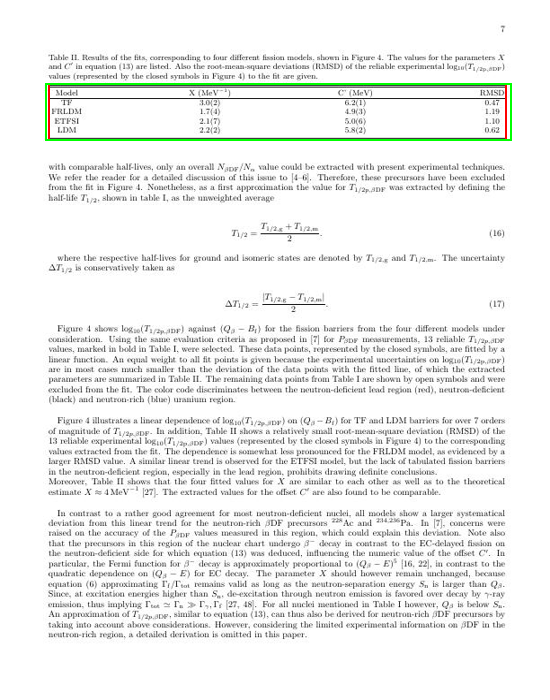

In [64]:
#Choose an index between 0 and 99 to show the sample images and the predictions

idx = 1

visualizeimg(sampledf,idx,0.95)


#Red boxes are ground truths, green boxes are predictions